# Assignment 2

we generate the Gnu KrigY model 

 $$
 \begin{pmatrix}
  d_1\\d_2\\...\\d_n 
  \end{pmatrix}
  \sim \mathcal{N}( 
   f(x)^T\beta
   , \mathbf{K_{\theta}(x_i,x_j)}_{i,j=1}^n+\sigma^2\mathbf{I})
 $$
 And we use generalized covariance function which is the principle irregular term from our Matérn covariance model.  For the kriging covariates, we use all monomials(of lat. and lon.) of order $\leq$ 2 and also include elevation as a covariate.  i.e. $\mathbf{K}_{\theta}=\frac{\sigma^2}{\rho^{2\nu}}c_{\nu}(2\nu)^{\nu}y(||x-y||)$
 As for the likelihood function, we use REML likelihood method to estimate the parameter.   
 Let $M^T=\text{nullspace}(f(x)^T)$, so that $$Md\sim \mathcal{N}(0, M(\sigma_g^2\mathbf{K}_{\theta}+\sigma_\varepsilon^2\mathbf{I})M^T)$$   
 In the module UKrig2, the main function generate_Gnu_krigY can precompute some matrix like distance matrix, Gnu matrix, and the matrix M. It will return two functions. The first can can make some prediction based on spline interpolator. The second one can compute the REML likelihood. 

In [4]:
include("../code/UKrig2.jl")
using PyPlot
using LinearAlgebra
using Statistics
using Random
using StaticArrays
import JLD2
using DynamicPolynomials

using .UKrig2



Load the Data

In [5]:


elv_obs    = JLD2.FileIO.load("../data/UStmax.jld2", "elv")
UStmax_obs = JLD2.FileIO.load("../data/UStmax.jld2", "UStmax")
lon_obs    = JLD2.FileIO.load("../data/UStmax.jld2", "lon")
lat_obs    = JLD2.FileIO.load("../data/UStmax.jld2", "lat")

elv_grid      = JLD2.FileIO.load("../data/krig_at.jld2", "elv_grid")
lat_grid_side = JLD2.FileIO.load("../data/krig_at.jld2", "lat_grid_side")
lon_grid_side = JLD2.FileIO.load("../data/krig_at.jld2", "lon_grid_side")


1×1405 Array{Float64,2}:
 -125.0  -124.958  -124.917  -124.875  …  -66.625  -66.5833  -66.5417  -66.5

## Case 1: $\nu=\frac{1}{2}$
we use the grid method to select the best parameter. we choose $\sigma g, \sigma \varepsilon$ in the set $0.5:0.1:1.4$

In [6]:
ν = 1/2
krig_ν, loglike_ν =generate_Gnu_krigY(UStmax_obs,lon_obs,lat_obs,elv_obs,ν)
n₁ = 10
n₂ = 10
σg_set = 0.5:1/n₁:1.4
σε_set = 0.5:1/n₂:1.4



result = loglike_ν.(σg_set .* ones(n₂)', ones(n₁) .* σε_set')
findmax(result)[2]


CartesianIndex(6, 4)

### draw the heatmap of the parameter grid matrix

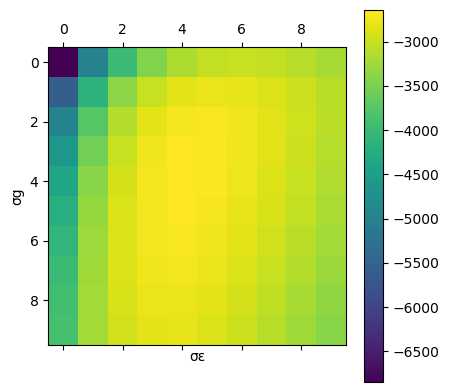

PyObject Text(0.5, 41.64444444444445, 'σε')

In [24]:
matshow(result,[])
colorbar()
ylabel("σg")
xlabel("σε")

using the grid method to select the parameter.   
The best parameter for $\nu=\frac{1}{2}$ is $\sigma g=1$, $\sigma\varepsilon=0.8$   
And the likelihood over this parameter

In [20]:
σg = 1
σε = 0.8
loglike_ν(σg,σε)

-2700.407232572321

### Now we can use our kriging model ( $\nu=\frac{1}{2}$) to make prediction 

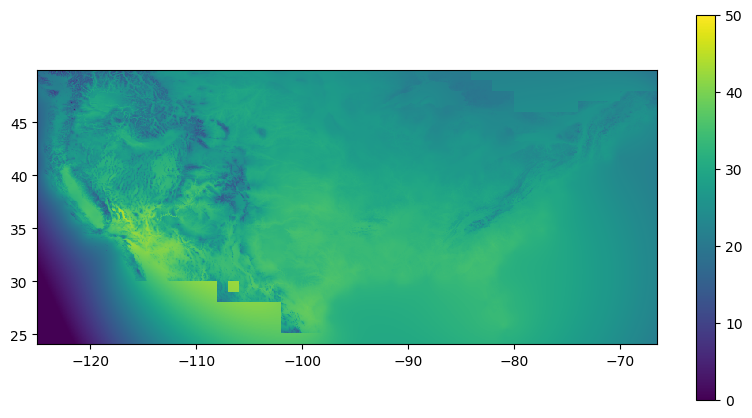

PyObject <matplotlib.colorbar.Colorbar object at 0x14cc11358>

In [10]:
σg = 1
σε = 0.8
ν  = 1/2
krig_ν, loglike_ν = generate_Gnu_krigY(UStmax_obs,lon_obs,lat_obs,elv_obs,ν)

m₁ = length(lon_grid_side)
m₂ = length(lat_grid_side)
A  = zeros(m₂,m₁)
for i in 1: m₁
    A[:,i] = krig_ν(σg,σε,ones(m₂) .* lon_grid_side[i], lat_grid_side[:,1], elv_grid[:,i])
end

#we can draw the figure of grid-temperature below 
figure(figsize=(10,5))
imshow(A,
    extent=(extrema(lon_grid_side)..., extrema(lat_grid_side)...),
    vmin=0, vmax=50
)
colorbar()

further test

### temperature grid prediction data

In [23]:
A

621×1405 Array{Float64,2}:
  17.5223    17.6316   17.7399   …  19.3395  19.2836  19.2272  19.1703
  17.5655    17.6754   17.7841      19.4123  19.3563  19.2997  19.2427
  17.6089    17.7194   17.8286      19.485   19.4288  19.3722  19.315 
  17.5015    17.7636   17.8734      19.5576  19.5013  19.4445  19.3871
  17.2983    17.522    17.9185      19.63    19.5736  19.5166  19.4592
  17.5986    17.402    17.7465   …  19.7023  19.6458  19.5887  19.531 
  17.485     17.8749   17.9866      19.7746  19.7178  19.6606  19.6028
  16.8522    17.387    17.9274      19.8466  19.7898  19.7323  19.6744
  16.0205    16.4646   17.4107      19.9186  19.8616  19.804   19.7459
  14.4132    15.4371   16.4596      19.9904  19.9332  19.8755  19.8172
  10.6735    12.2475   15.1472   …  20.0621  20.0047  19.9468  19.8883
  10.7256     8.85439  12.0114      20.1337  20.0761  20.018   19.9593
  16.0501    14.4271    9.29455     20.2051  20.1473  20.089   20.0302
   ⋮                             ⋱                

## Case2：$\nu=\frac{3}{2}$
we use the grid method to select the best parameter.   
$\sigma g$ in the set $0.1:0.1:1$,  
$\sigma \varepsilon$ in the set $0.5:0.1:1.4$

In [26]:
ν  = 3/2
krig_ν, loglike_ν = generate_Gnu_krigY(UStmax_obs,lon_obs,lat_obs,elv_obs,ν)
n₁ = 10
n₂ = 10
σg_set = 0.1:1/n₁:1
σε_set = 0.5:1/n₂:1.4

result = loglike_ν.(σg_set .* ones(n₂)', ones(n₁) .* σε_set')
findmax(result)[2]

CartesianIndex(5, 5)

### draw the heatmap of the parameter grid matrix

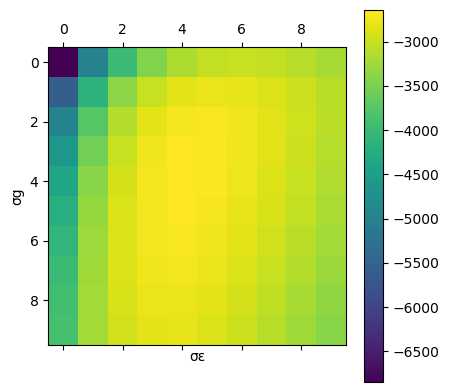

PyObject Text(0.5, 41.64444444444445, 'σε')

In [74]:
matshow(result)
colorbar()
ylabel("σg")
xlabel("σε")
#axis([0.5,1.4,0.1,1])
#axis("image")
#axis()
#xlim(0.1,1)

#result

The best parameter for $\nu=\frac{3}{2}$ is $\sigma g=0.5$, $\sigma\varepsilon=0.9$  
and the likelihood over this parameter is shown below.  


In [25]:
σg = 0.5
σε = 0.9
ν = 3/2
krig_ν, loglike_ν = generate_Gnu_krigY(UStmax_obs,lon_obs,lat_obs,elv_obs,ν)
loglike_ν(σg,σε)

-2641.129801169445

   ### Comparing the likelihood with the $\nu=\frac{1}{2}$ case, we found that $\nu=\frac{3}{2}$ is better.

### Now we can use our kriging model( $\nu=\frac{3}{2}$) to make prediction 

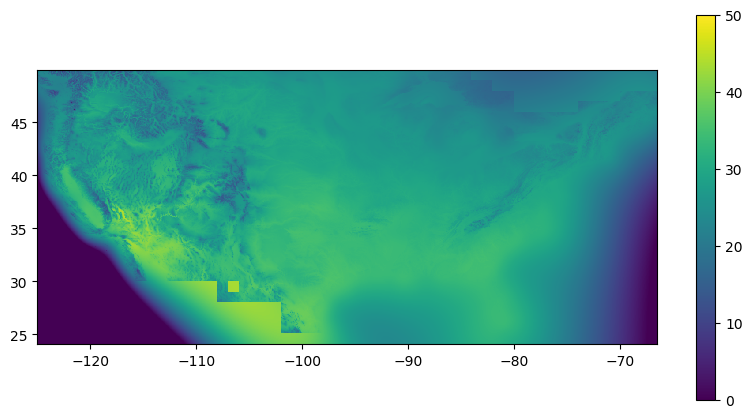

PyObject <matplotlib.colorbar.Colorbar object at 0x14f7f91d0>

In [9]:
σg = 0.5
σε = 0.9
ν  = 3/2
krig_ν, loglike_ν = generate_Gnu_krigY(UStmax_obs,lon_obs,lat_obs,elv_obs,ν)


m₁ = length(lon_grid_side)
m₂ = length(lat_grid_side)
A  = zeros(m₂,m₁)
for i in 1: m₁
    A[:,i]=krig_ν(σg,σε,ones(m₂).*lon_grid_side[i],lat_grid_side[:,1],elv_grid[:,i])
end

#we can draw the figure of grid-temperature below 
figure(figsize=(10,5))
imshow(A,
    extent=(extrema(lon_grid_side)..., extrema(lat_grid_side)...),
    vmin=0, vmax=50
)
colorbar()